In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import random as r
from sklearn.model_selection import train_test_split
from functions import mtr


dt = pd.read_csv('../data/model4.csv').dropna()
# dt['car'] = dt['TS_MARK_NAME'] + ' ' + dt['TS_MODEL_NAME']

# откуда то при пересохранении в csv образуется лишний столбец
dt.drop(dt.columns[[0]], axis = 1, inplace = True)

dt.OWN_REG = dt.OWN_REG.apply(lambda x: str(x))
dt = dt[(dt['TS_POWER'] < 1000) & (dt['TS_POWER'] > 30) & (dt['INS_YEAR'] > 18)]
dt = dt[['AGR_SRC', 'AGR_CREATEDBY',#, 'car' 
       'OWN_REG', 'AGR_KBM', 'TS_MARK_NAME', 'TS_MODEL_NAME',
       'TS_POWER', 'TS_USE_NAME', 'f1_daysbeforestart',
       'f6_car_age_on_start', 'f13_is_prolongation', 'f14_drivers_count',
       'f15_kbm_min', 'f16_drv_age_min', 'f17_drv_age_max',
       'f18_drv_skill_min', 'f19_drv_skill_max', 'f20_oneperson',
       'f21_agr_days', 'claim']]

# балансируем классы и разбиваем на выборки
dt['cat'] = dt['claim'].apply(lambda x: r.choice(list(range(1, 6))) if x==1 else r.choice(list(range(10, 30))))
trn = dt[dt['cat'].isin([10, 2, 3, 4, 5, 22, 23, 24, 25, 26, 27, 28, 29])]
tst = dt[dt['cat'].isin([1,11, 12, 13, 14, 15])].drop('cat', axis = 1)

dt2 = trn[(trn['AGR_KBM'] < 0.95) & (trn['AGR_KBM'] > 1)]
dt3 = trn[trn['claim'] == 1]
# print(dt3.shape, Counter(dt3.claim))
dt = dt.append(dt2).append(dt3)


# пополняем выборку значениями upsample
trn = dt[dt['cat'].isin([10, 2, 3, 4, 5, 22,])].drop('cat', axis = 1)

# for c in dt.columns:
#     col_type = dt[c].dtype
#     if col_type == 'object' or col_type.name == 'category':
#         X[c] = dt[c].astype('category')




X = dt.drop(['claim'], axis = 1)
Y = dt.claim


X_train = trn.drop(['claim'], axis = 1)
X_test = tst.drop(['claim'], axis = 1)
y_train = trn.claim
y_test = tst.claim

print(Counter(y_train), Counter(y_test))

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (7,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Counter({0: 7378, 1: 5622}) Counter({0: 18693, 1: 749})


In [2]:
from catboost import CatBoostClassifier, Pool

categorical_features = ['AGR_CREATEDBY', 'OWN_REG', 'AGR_SRC', #'car',
                         'TS_MODEL_NAME', 'TS_MARK_NAME',
       'TS_USE_NAME']

text_features = []#['INS_NAME']

cat_features_index = list(X_train.columns.get_loc(feature) for feature in categorical_features)
text_features_index = list(X_train.columns.get_loc(feature) for feature in text_features)

In [8]:
modelcb = CatBoostClassifier(
#                 learning_rate=0.01,
                l2_leaf_reg=2,
#                 grow_policy = 'Lossguide',
                loss_function='Logloss',
#                 depth=16,
#                 iterations=30,
                eval_metric='AUC', #AUC, F1
                cat_features=cat_features_index,
                text_features=text_features_index,
                random_seed=42,
                logging_level='Silent',
                task_type="GPU",
#                 devices='1'
            )

modelcb.fit(X_train, y_train)

mtr(modelcb, x = X_test, y = y_test, limit = 1, metrics = 'AUC')

Оптимальный лимит:  0.4678734375

Всего доход у нового метода:  60 224 514.0
Всего доход у текущего метода:  61 074 492.0
Доход больше, чем у текущего метода на  -1.41 %

[[18033   660]
 [  701    48]]

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     18693
           1       0.07      0.06      0.07       749

    accuracy                           0.93     19442
   macro avg       0.52      0.51      0.51     19442
weighted avg       0.93      0.93      0.93     19442


ROC-AUC score:  0.5143890564833784


In [4]:
mtr(modelcb, x = X, y = Y, limit = 1, metrics = 'money')

Оптимальный лимит:  0.51523671875

Всего доход у нового метода:  360 535 880.0
Всего доход у текущего метода:  38 947 623.0
Доход больше, чем у текущего метода на  89.2 %

[[71227  3405]
 [  745  5626]]

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     74632
           1       0.62      0.88      0.73      6371

    accuracy                           0.95     81003
   macro avg       0.81      0.92      0.85     81003
weighted avg       0.96      0.95      0.95     81003


ROC-AUC score:  0.9187200110712433


In [239]:
# modelcb.save_model('../models/cb_model4_v2_06214.cbm', format="cbm")

Text(0.5, 0, 'Relative Importance')

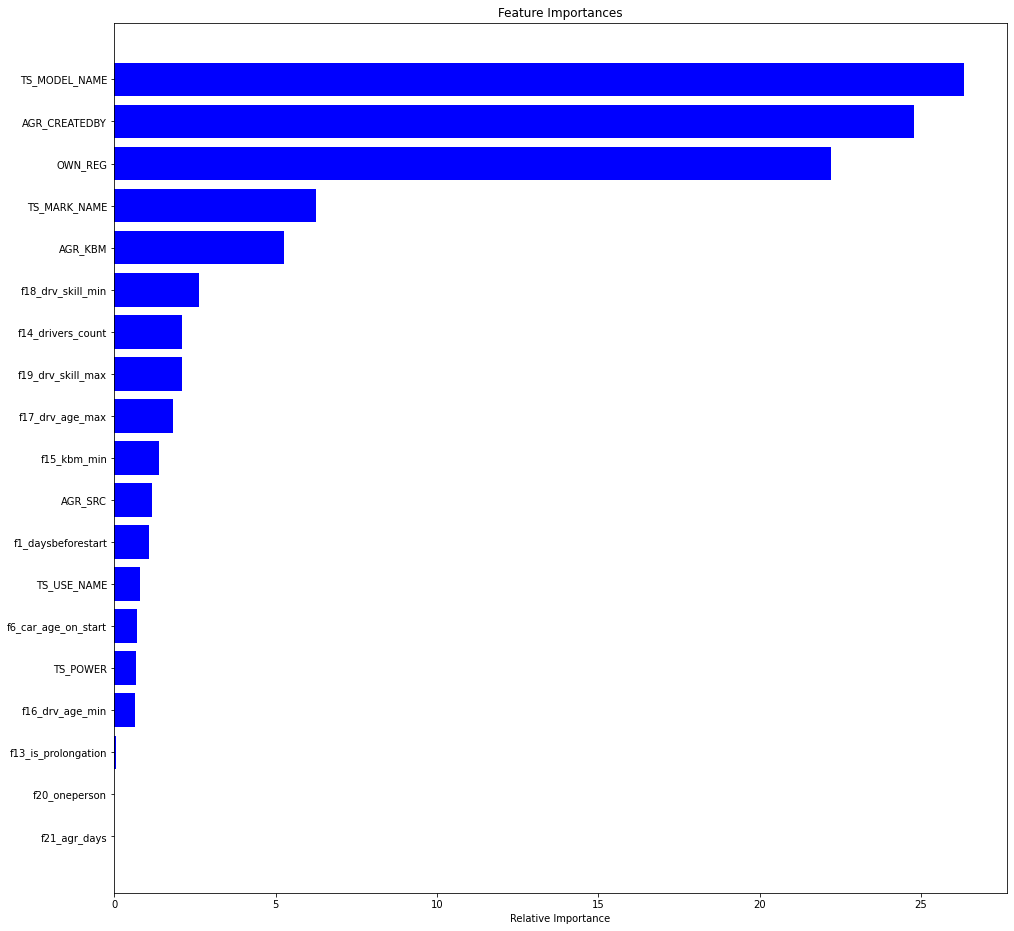

In [9]:
import matplotlib.pyplot as plt

features=X_train.columns
importances = modelcb.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(16, 16))
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

In [422]:
pr = modelcb.predict(X_test)
res = X_test
res['pred'] = pr
res['truth'] = y_test
a = confusion_matrix(y_test, pr)
print(a)
# res[(res['pred'] == res['truth']) & res['pred'] == 1]
# a[0][0] + a[1][0] - a[1][0]


[[28947 12069]
 [  119  1285]]


<AxesSubplot:xlabel='AGR_KBM'>

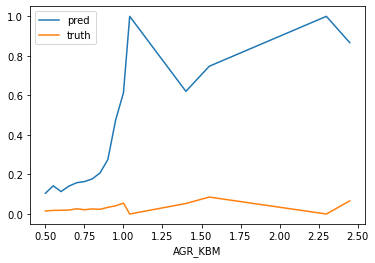

In [429]:
kbmmean = res.groupby(['AGR_KBM']).mean()[['pred', 'truth']]
kbmmean.plot()

<ipython-input-424-5428cfd64a61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  powermean['TS_POWER_G'] = powermean['TS_POWER'].apply(lambda x: round(x * 2, -2) // 2)


<AxesSubplot:xlabel='TS_POWER_G'>

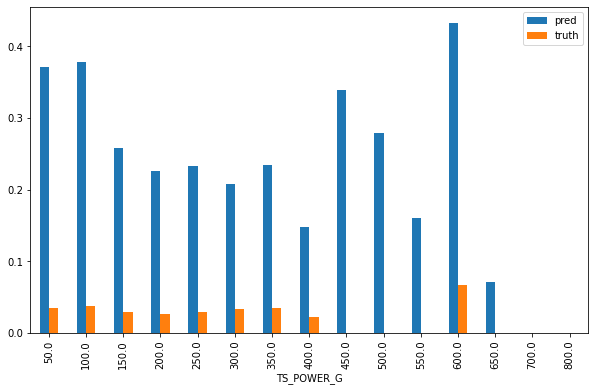

In [424]:
powermean = res[['TS_POWER', 'pred', 'truth']]
powermean['TS_POWER_G'] = powermean['TS_POWER'].apply(lambda x: round(x * 2, -2) // 2)
powermean = powermean.groupby(['TS_POWER_G']).mean()[['pred', 'truth']].sort_values(by='TS_POWER_G', ascending=True)
powermean.plot(kind = 'bar', figsize=(10, 6))

# powermean.head()
# powermean.plot(kind = 'bar', figsize=(10, 6))

<AxesSubplot:xlabel='TS_MARK_NAME'>

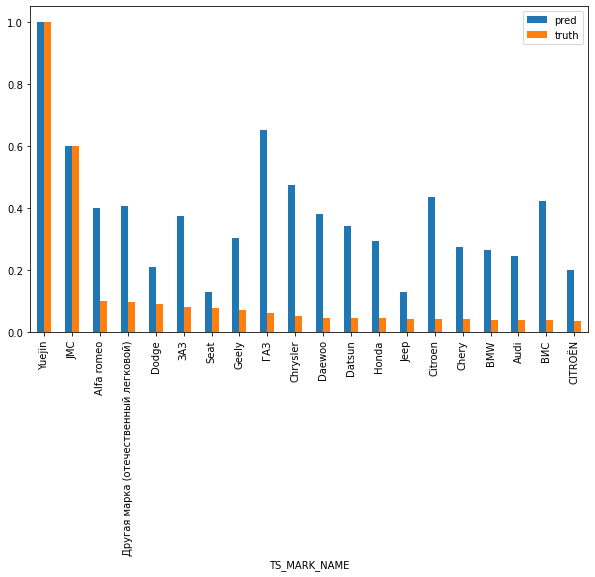

In [425]:
#аварийность по маркам

markmean = res.groupby(['TS_MARK_NAME']).mean()[['pred', 'truth']].sort_values(by='truth', ascending=False)
markmean.head(20).plot(kind = 'bar', figsize=(10, 6))

<AxesSubplot:xlabel='OWN_REG'>

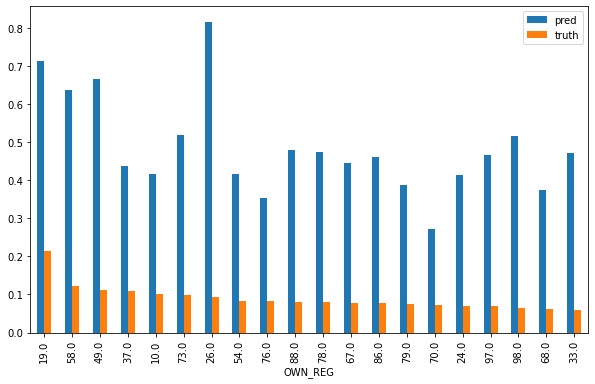

In [426]:
#аварийность по регионам

regmean = res.groupby(['OWN_REG']).mean()[['pred', 'truth']].sort_values(by='truth', ascending=False)
regmean.head(20).plot(kind = 'bar', figsize=(10, 6))

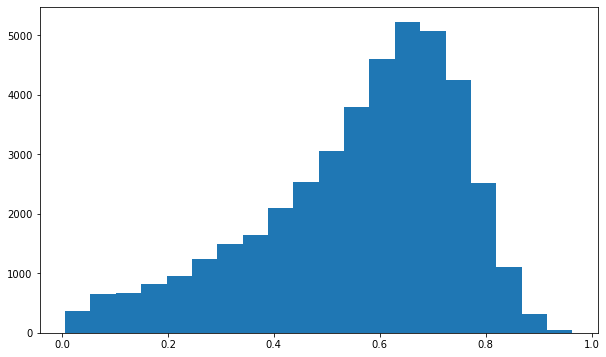

In [427]:
# распределение вероятности внутри результата

pr = modelcb.predict_proba(X_test)
proba = [a[0] for a in pr]
proba

plt.figure(figsize=(10, 6))
plt.hist(proba, bins=20)
plt.show()